In [ ]:
import holidays
import squarify
import numpy as np
import pandas as pd
import seaborn as sns
from minisom import MiniSom
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram

hotel = pd.read_csv('COLUMBIA_CAPSTONE_1M_FINAL_DATASET.csv', sep="|", header=None)
hotel.columns = ['CUSTOMER_ID', 'CALENDAR_YEAR', 'CALENDAR_MONTH', 'PRODUCT_CATEGORY', 'LATEST_TRANSACTION_DATE',
                 'NUM_TRANSACTIONS', 'TOTAL_SPEND', 'MARRIOTT_REVENUE']
hotel['LATEST_TRANSACTION_DATE'] = pd.to_datetime(hotel['LATEST_TRANSACTION_DATE'])
hotel.head()

,CUSTOMER_ID,CALENDAR_YEAR,CALENDAR_MONTH,PRODUCT_CATEGORY,LATEST_TRANSACTION_DATE,NUM_TRANSACTIONS,TOTAL_SPEND,MARRIOTT_REVENUE
0,313533313938323732,2013,1,Hotel Room,2013-01-12,2.0,191.41,8.00
1,313539383432323632,2008,2,Hotel Room,2008-02-14,5.0,1758.20,67.37
2,313936373136313930,2002,7,Hotel Room,2002-07-31,3.0,345.34,13.24
3,313936373136313930,2014,9,Hotel Room,2014-09-03,2.0,173.60,6.32
4,313533313938323935,2013,11,Hotel Room,2013-11-24,2.0,715.86,31.58


## 0 CLV customer Selection


In [ ]:
len(hotel)

10170768

The unique cusomers

In [ ]:

hotel_unique = hotel.drop_duplicates(subset=['CUSTOMER_ID'])
len(hotel_unique)

1000000

The unique cusomers in 2021

In [ ]:
customers_2021_hotel = hotel[hotel['CALENDAR_YEAR'] == 2021]['CUSTOMER_ID'].nunique()
customers_2021_hotel

238329

The unique customers in 2021 or 2022

In [ ]:
customers_2020_2021_hotel = hotel[hotel['CALENDAR_YEAR'].isin([2022, 2021])]['CUSTOMER_ID'].nunique()
customers_2020_2021_hotel

381440

#### Select the customers that hvae records both in 2021 before 2021

In [ ]:
customers_before_2021_ids = hotel[(hotel['CALENDAR_YEAR'] < 2021)]['CUSTOMER_ID'].unique()
customers_2021_ids = hotel[hotel['CALENDAR_YEAR'] == 2021]['CUSTOMER_ID'].unique()
both_years_ids = set(customers_before_2021_ids) & set(customers_2021_ids)
len(both_years_ids)

114848

In [ ]:
hotel = hotel[hotel['CUSTOMER_ID'].isin(both_years_ids)]
len(hotel)

5880634

### Independent Variable

In [ ]:
revenue_2021 = hotel[hotel['CALENDAR_YEAR'] == 2021].groupby('CUSTOMER_ID')['MARRIOTT_REVENUE'].sum()
len(revenue_2021)

114848

In [ ]:
revenue_2021.head()

CUSTOMER_ID
3431       17.12
333339    352.63
353130     26.05
353730     97.59
353832     22.38
Name: MARRIOTT_REVENUE, dtype: float64

In [ ]:
revenue_2021.head()

CUSTOMER_ID
3431       17.12
333339    352.63
353130     26.05
353730     97.59
353832     22.38
Name: MARRIOTT_REVENUE, dtype: float64

### Build features on data before 2021.


In [ ]:
hotel = hotel[(hotel['CALENDAR_YEAR'] != 2021) & (hotel['CALENDAR_YEAR'] != 2022)]

## 1 Feature Engineering

#### Feature 1 Classic Recency: Last Transaction Date ~ Today (2022-10-02)
- For this feature ONLY, new customers have a lower Recency Score AFTER NORMALIZATION, however, they have a higher Recency score BEFORE NORMALIZATION.

In [ ]:
# Calculate Recency
latest_date = hotel['LATEST_TRANSACTION_DATE'].max()
hotel['Last_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('max')
hotel['Recency'] = (latest_date - hotel['Last_Transaction_Date']).dt.days
hotel.drop('Last_Transaction_Date', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,Recency
0,313533313938323732,0
1,313539383432323632,68
2,313936373136313930,0
3,313936373136313930,0
5,313539383738303333,48


#### Feature 2 Classic Frequency: # of Transactions in Recent 2 Years

In [ ]:
# Calculate Frequency
hotel['LATEST_TRANSACTION_DATE'] = pd.to_datetime(hotel['LATEST_TRANSACTION_DATE'])
latest_date = hotel['LATEST_TRANSACTION_DATE'].max()
two_years = latest_date - timedelta(days=730)

hotel['Frequency'] = hotel[hotel['LATEST_TRANSACTION_DATE']
                           >= two_years].groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].transform('sum')
hotel['Frequency'] = hotel.groupby('CUSTOMER_ID')['Frequency'].transform(lambda x: x.fillna(0)
                                                                         if x.isnull().all()
                                                                         else x.fillna(x.mean()))

# Fill NaNs with 0
hotel['Frequency'].fillna(0, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,Frequency
0,313533313938323732,1133.0
1,313539383432323632,46.0
2,313936373136313930,1282.0
3,313936373136313930,1282.0
5,313539383738303333,147.0


#### Feature 3 Classic Monetary - Total Amount of 'TOTAL_SPEND'

In [ ]:
monetary = hotel.groupby('CUSTOMER_ID')['TOTAL_SPEND'].sum().reset_index()
monetary.rename(columns={'TOTAL_SPEND': 'Monetary'}, inplace=True)
hotel = hotel.merge(monetary, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,Monetary
0,313533313938323732,126725.66
1,313539383432323632,358225.36
2,313936373136313930,183934.83
3,313936373136313930,183934.83
4,313539383738303333,345668.00


#### Feature 4 FirstRecency: First Transaction Date ~ Today (2022-10-02)

In [ ]:
# Calculate FirstRecency
latest_date = hotel['LATEST_TRANSACTION_DATE'].max()
hotel['First_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('min')
hotel['FirstRecency'] = (latest_date - hotel['First_Transaction_Date']).dt.days
hotel.drop('First_Transaction_Date', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FirstRecency
0,313533313938323732,5277
1,313539383432323632,7246
2,313936373136313930,7288
3,313936373136313930,7288
4,313539383738303333,7274


#### Feature 5 LifetimeRecency: First Transaction Date ~ Last Transaction Date

In [ ]:
hotel['Last_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('max')
hotel['First_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('min')
hotel['LifetimeRecency'] = (hotel['Last_Transaction_Date'] - hotel['First_Transaction_Date']).dt.days
hotel.drop('Last_Transaction_Date', axis=1, inplace=True)
hotel.drop('First_Transaction_Date', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,LifetimeRecency
0,313533313938323732,5277
1,313539383432323632,7178
2,313936373136313930,7288
3,313936373136313930,7288
4,313539383738303333,7226


#### Feature 6 Yearly Frequency: # of Transactions per Year

In [ ]:
grouped = hotel.groupby('CUSTOMER_ID').agg(earliest_date=('LATEST_TRANSACTION_DATE', 'min'),
                                           TotalNumOfTransactions=('NUM_TRANSACTIONS', 'sum')).reset_index()
grouped['CustomerYear'] = (latest_date - grouped['earliest_date']).dt.days / 365
grouped['YearlyFrequency'] = np.where(grouped['CustomerYear'] < 1,
                                      grouped['TotalNumOfTransactions'],
                                      grouped['TotalNumOfTransactions'] / grouped['CustomerYear'])
hotel = hotel.merge(grouped[['CUSTOMER_ID', 'YearlyFrequency']], on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,YearlyFrequency
0,313533313938323732,127.684290
1,313539383432323632,58.835219
2,313936373136313930,119.396268
3,313936373136313930,119.396268
4,313539383738303333,83.497388


#### Feature 7 Average Frequency: Average Time Interval Between Transactions

In [ ]:
hotel = hotel.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel['TimeInterval'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].diff().dt.days
hotel['AverageFrequency'] = hotel.groupby('CUSTOMER_ID')['TimeInterval'].transform('mean')
hotel['AverageFrequency'] = hotel.groupby('CUSTOMER_ID')['AverageFrequency'].transform('first')
hotel.drop('TimeInterval', axis=1, inplace=True)
hotel = hotel.sort_index()

# Fill NaNs with Median - to be discussed
median_value = hotel['AverageFrequency'].median()
hotel['AverageFrequency'].fillna(median_value, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,AverageFrequency
0,313533313938323732,30.859649
1,313539383432323632,26.293040
2,313936373136313930,27.092937
3,313936373136313930,27.092937
4,313539383738303333,15.986726


#### Feature 8 SD Frequency: Standard Deviation of Interval - To Measure Stability

In [ ]:
hotel = hotel.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel['TimeInterval'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].diff().dt.days
hotel['SDFrequency'] = hotel.groupby('CUSTOMER_ID')['TimeInterval'].transform('std')
hotel['SDFrequency'] = hotel.groupby('CUSTOMER_ID')['SDFrequency'].transform('first')
hotel = hotel.sort_index()
hotel.drop('TimeInterval', axis=1, inplace=True)

# Fill NaNs with Median - to be discussed
median_value = hotel['SDFrequency'].median()
hotel['SDFrequency'].fillna(median_value, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,SDFrequency
0,313533313938323732,55.776689
1,313539383432323632,46.771447
2,313936373136313930,41.581007
3,313936373136313930,41.581007
4,313539383738303333,18.050430


#### Feature 9 Average Monetary - Average Amount of 'TOTAL_SPEND'

In [ ]:
grouped = hotel.groupby('CUSTOMER_ID')['TOTAL_SPEND'].mean().reset_index()
grouped.rename(columns={'TOTAL_SPEND': 'AverageMonetary'}, inplace=True)
hotel = hotel.merge(grouped, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,AverageMonetary
0,313533313938323732,736.777093
1,313539383432323632,1307.391825
2,313936373136313930,681.240111
3,313936373136313930,681.240111
4,313539383738303333,763.064018


#### Feature 10 Recent Monetary - Total Amount of 'TOTAL_SPEND' in Recent 2 Years

In [ ]:
grouped = hotel[hotel['LATEST_TRANSACTION_DATE'] >= two_years].groupby('CUSTOMER_ID')['TOTAL_SPEND'].sum().reset_index()
grouped.rename(columns={'TOTAL_SPEND': 'RecentMonetary'}, inplace=True)
hotel = hotel.merge(grouped, on='CUSTOMER_ID', how='left')
hotel['RecentMonetary'].fillna(0, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,RecentMonetary
0,313533313938323732,60147.30
1,313539383432323632,4755.88
2,313936373136313930,86626.01
3,313936373136313930,86626.01
4,313539383738303333,27665.04


#### Feature 11 Quarterly Bias (NoT) - Quarter with the Highest # of Transactions

In [ ]:
hotel['Quarter'] = hotel['LATEST_TRANSACTION_DATE'].dt.quarter
quarterly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Quarter'])['NUM_TRANSACTIONS'].sum().reset_index()
max_quarterly_orders = quarterly_order_counts.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].idxmax()
result = quarterly_order_counts.loc[max_quarterly_orders][['CUSTOMER_ID', 'Quarter']]
result.rename(columns={'Quarter': 'FQuarterlyBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel.drop('Quarter', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FQuarterlyBias
0,313533313938323732,4
1,313539383432323632,1
2,313936373136313930,3
3,313936373136313930,3
4,313539383738303333,3


#### Feature 12 Quarterly Bias (NoT - SD) - Standard Deviation of Quarterly # of Transactions

In [ ]:
hotel['Quarter'] = hotel['LATEST_TRANSACTION_DATE'].dt.quarter
quarterly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Quarter'])['NUM_TRANSACTIONS'].sum().reset_index()
quarterly_order_std = quarterly_order_counts.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].std().reset_index()
quarterly_order_std.rename(columns={'NUM_TRANSACTIONS': 'FQuarterlyBiasSD'}, inplace=True)
hotel = hotel.merge(quarterly_order_std, on='CUSTOMER_ID', how='left')
hotel.drop('Quarter', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FQuarterlyBiasSD
0,313533313938323732,63.084599
1,313539383432323632,58.223707
2,313936373136313930,128.913408
3,313936373136313930,128.913408
4,313539383738303333,50.292478


#### Feature 13 Monthly Bias (NoT) - Month with the Highest # of Transactions

In [ ]:
hotel['Month'] = hotel['LATEST_TRANSACTION_DATE'].dt.month
monthly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Month'])['NUM_TRANSACTIONS'].sum().reset_index()
max_monthly_orders = monthly_order_counts.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].idxmax()
result = monthly_order_counts.loc[max_monthly_orders][['CUSTOMER_ID', 'Month']]
result.rename(columns={'Month': 'FMonthlyBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel.drop('Month', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FMonthlyBias
0,313533313938323732,12
1,313539383432323632,1
2,313936373136313930,12
3,313936373136313930,12
4,313539383738303333,8


#### Feature 14 Monthly Bias (NoT - SD) - Standard Deviation of Monthly # of Transactions

In [ ]:
hotel['Month'] = hotel['LATEST_TRANSACTION_DATE'].dt.month
monthly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Month'])['NUM_TRANSACTIONS'].sum().reset_index()
monthly_order_std = monthly_order_counts.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].std().reset_index()
monthly_order_std.rename(columns={'NUM_TRANSACTIONS': 'FMonthlyBiasSD'}, inplace=True)
hotel = hotel.merge(monthly_order_std, on='CUSTOMER_ID', how='left')
hotel.drop('Month', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FMonthlyBiasSD
0,313533313938323732,31.120976
1,313539383432323632,33.431975
2,313936373136313930,47.323516
3,313936373136313930,47.323516
4,313539383738303333,24.016409


#### Feature 15 Quarterly Bias (M) - Quarter with the Highest Total Spend

In [ ]:
hotel['Quarter'] = hotel['LATEST_TRANSACTION_DATE'].dt.quarter
quarterly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Quarter'])['TOTAL_SPEND'].sum().reset_index()
max_quarterly_orders = quarterly_order_counts.groupby('CUSTOMER_ID')['TOTAL_SPEND'].idxmax()
result = quarterly_order_counts.loc[max_quarterly_orders][['CUSTOMER_ID', 'Quarter']]
result.rename(columns={'Quarter': 'MQuarterlyBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel.drop('Quarter', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MQuarterlyBias
0,313533313938323732,4
1,313539383432323632,1
2,313936373136313930,3
3,313936373136313930,3
4,313539383738303333,3


#### Feature 16 Quarterly Bias (M - SD) - Standard Deviation of Quarterly Total Spend

In [ ]:
hotel['Quarter'] = hotel['LATEST_TRANSACTION_DATE'].dt.quarter
quarterly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Quarter'])['TOTAL_SPEND'].sum().reset_index()
quarterly_order_std = quarterly_order_counts.groupby('CUSTOMER_ID')['TOTAL_SPEND'].std().reset_index()
quarterly_order_std.rename(columns={'TOTAL_SPEND': 'MQuarterlyBiasSD'}, inplace=True)
hotel = hotel.merge(quarterly_order_std, on='CUSTOMER_ID', how='left')
hotel.drop('Quarter', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MQuarterlyBiasSD
0,313533313938323732,5692.695468
1,313539383432323632,24815.515534
2,313936373136313930,6396.157541
3,313936373136313930,6396.157541
4,313539383738303333,6454.500609


#### Feature 17 Monthly Bias (M) - Month with the Highest Total Spend

In [ ]:
hotel['Month'] = hotel['LATEST_TRANSACTION_DATE'].dt.month
monthly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Month'])['TOTAL_SPEND'].sum().reset_index()
max_monthly_orders = monthly_order_counts.groupby('CUSTOMER_ID')['TOTAL_SPEND'].idxmax()
result = monthly_order_counts.loc[max_monthly_orders][['CUSTOMER_ID', 'Month']]
result.rename(columns={'Month': 'MMonthlyBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel.drop('Month', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MMonthlyBias
0,313533313938323732,12
1,313539383432323632,4
2,313936373136313930,7
3,313936373136313930,7
4,313539383738303333,10


#### Feature 18 Monthly Bias (M - SD) - Standard Deviation of Monthly Total Spend

In [ ]:
hotel['Month'] = hotel['LATEST_TRANSACTION_DATE'].dt.month
monthly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Month'])['TOTAL_SPEND'].sum().reset_index()
monthly_order_std = monthly_order_counts.groupby('CUSTOMER_ID')['TOTAL_SPEND'].std().reset_index()
monthly_order_std.rename(columns={'TOTAL_SPEND': 'MMonthlyBiasSD'}, inplace=True)
hotel = hotel.merge(monthly_order_std, on='CUSTOMER_ID', how='left')
hotel.drop('Month', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MMonthlyBiasSD
0,313533313938323732,2700.302804
1,313539383432323632,17727.719697
2,313936373136313930,3714.767550
3,313936373136313930,3714.767550
4,313539383738303333,6761.182777


#### Feature 19 Product Bias (NoT) - Product with the Highest # of Transactions

In [ ]:
product_category = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['NUM_TRANSACTIONS'].sum().reset_index()
max_product_category = product_category.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].idxmax()
result = product_category.loc[max_product_category][['CUSTOMER_ID', 'PRODUCT_CATEGORY']]
result.rename(columns={'PRODUCT_CATEGORY': 'FProductBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FProductBias
0,313533313938323732,Card - Basic
1,313539383432323632,Hotel Room
2,313936373136313930,Card - Basic
3,313936373136313930,Card - Basic
4,313539383738303333,Hotel Room


#### Feature 20 Product Bias (M) - Product with the Highest Total Spend

In [ ]:
product_category = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['TOTAL_SPEND'].sum().reset_index()
max_product_category = product_category.groupby('CUSTOMER_ID')['TOTAL_SPEND'].idxmax()
result = product_category.loc[max_product_category][['CUSTOMER_ID', 'PRODUCT_CATEGORY']]
result.rename(columns={'PRODUCT_CATEGORY': 'MProductBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MProductBias
0,313533313938323732,Card - Basic
1,313539383432323632,Hotel Room
2,313936373136313930,Card - Basic
3,313936373136313930,Card - Basic
4,313539383738303333,Hotel Room


#### Feature 21 Monthly SD - Standard  Deviation of Monthly Total Spend
- This feature is different from feature 18 in that feature 18 calculates the stability of customers from month to month, e.g., some people spend 5,000 USD in December and only 5 USD in other months, and the TOTAL SPEND for each month is calculated by adding up the TOTAL SPEND for that month in EACH YEAR.
- However, this feature is calculated as the standard deviation between EACH MONTH, from the month in which that customers first spendd to the month in which they last spend.

In [ ]:
monthly_spend_std = hotel.groupby('CUSTOMER_ID')['TOTAL_SPEND'].std().reset_index()
monthly_spend_std.rename(columns={'TOTAL_SPEND': 'MonthlySD'}, inplace=True)
hotel = hotel.merge(monthly_spend_std, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MonthlySD
0,313533313938323732,1277.619847
1,313539383432323632,2040.379348
2,313936373136313930,1253.602169
3,313936373136313930,1253.602169
4,313539383738303333,776.310499


#### Feature 22 Monthly Growth (M) - Average Growth Rate of Monthly Total Spend

In [ ]:
hotel_c = hotel.copy()
hotel_c = hotel_c.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c = hotel_c[hotel_c['TOTAL_SPEND'] > 0]
hotel_c['MonthlyTotalSpend'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.strftime('%Y-%m')])['TOTAL_SPEND'].transform('sum')
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['MonthlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['MonthlyTotalSpend'].pct_change()
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'CALENDAR_MONTH'])
average_monthly_growth = hotel_c.groupby('CUSTOMER_ID')['MonthlyGrowth'].mean().reset_index()
average_monthly_growth.rename(columns={'MonthlyGrowth': 'MMonthlyGrowth'}, inplace=True)
hotel_c = hotel_c.merge(average_monthly_growth, on='CUSTOMER_ID', how='left')
hotel_c = hotel_c[['CUSTOMER_ID', 'MMonthlyGrowth']].drop_duplicates(subset=['CUSTOMER_ID'])
hotel = hotel.merge(hotel_c, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MMonthlyGrowth
0,313533313938323732,2.439278
1,313539383432323632,-0.098687
2,313936373136313930,1.517801
3,313936373136313930,1.517801
4,313539383738303333,0.087590


#### Feature 23 Yearly Growth (M) - Average Growth Rate of Yearly Total Spend

In [ ]:
hotel_c = hotel.copy()
hotel_c = hotel_c.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c = hotel_c[hotel_c['TOTAL_SPEND'] > 0]
hotel_c['YearlyTotalSpend'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.year])['TOTAL_SPEND'].transform('sum')
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['YearlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['YearlyTotalSpend'].pct_change()
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'CALENDAR_YEAR'])
average_yearly_growth = hotel_c.groupby('CUSTOMER_ID')['YearlyGrowth'].mean().reset_index()
average_yearly_growth.rename(columns={'YearlyGrowth': 'MYearlyGrowth'}, inplace=True)
hotel_c = hotel_c.merge(average_yearly_growth, on='CUSTOMER_ID', how='left')
hotel_c = hotel_c[['CUSTOMER_ID', 'MYearlyGrowth']].drop_duplicates(subset=['CUSTOMER_ID'])
hotel = hotel.merge(hotel_c, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MYearlyGrowth
0,313533313938323732,3.189711
1,313539383432323632,1.041617
2,313936373136313930,4.075900
3,313936373136313930,4.075900
4,313539383738303333,0.016734


#### Feature 24 Monthly Growth (NoT) - Average Growth Rate of Monthly # of Transactions

In [ ]:
hotel_c = hotel.copy()
hotel_c = hotel_c.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['MonthlyTotalTransactions'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.strftime('%Y-%m')])['NUM_TRANSACTIONS'].transform('sum')
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['MonthlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['MonthlyTotalTransactions'].pct_change()
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'CALENDAR_MONTH'])
average_monthly_growth = hotel_c.groupby('CUSTOMER_ID')['MonthlyGrowth'].mean().reset_index()
average_monthly_growth.rename(columns={'MonthlyGrowth': 'FMonthlyGrowth'}, inplace=True)
hotel_c = hotel_c.merge(average_monthly_growth, on='CUSTOMER_ID', how='left')
hotel_c = hotel_c[['CUSTOMER_ID', 'FMonthlyGrowth']].drop_duplicates(subset=['CUSTOMER_ID'])
hotel = hotel.merge(hotel_c, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FMonthlyGrowth
0,313533313938323732,0.045455
1,313539383432323632,0.033117
2,313936373136313930,0.121212
3,313936373136313930,0.121212
4,313539383738303333,0.182231


#### Feature 25 Yearly Growth (NoT) - Average Growth Rate of Yearly  # of Transactions

In [ ]:
hotel_c = hotel.copy()
hotel_c = hotel_c.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['YearlyTotalTransactions'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.year])['NUM_TRANSACTIONS'].transform('sum')
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['YearlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['YearlyTotalTransactions'].pct_change()
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'CALENDAR_YEAR'])
average_yearly_growth = hotel_c.groupby('CUSTOMER_ID')['YearlyGrowth'].mean().reset_index()
average_yearly_growth.rename(columns={'YearlyGrowth': 'FYearlyGrowth'}, inplace=True)
hotel_c = hotel_c.merge(average_yearly_growth, on='CUSTOMER_ID', how='left')
hotel_c = hotel_c[['CUSTOMER_ID', 'FYearlyGrowth']].drop_duplicates(subset=['CUSTOMER_ID'])
hotel = hotel.merge(hotel_c, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FYearlyGrowth
0,313533313938323732,2.058696
1,313539383432323632,0.249994
2,313936373136313930,2.909823
3,313936373136313930,2.909823
4,313539383738303333,0.042959


#### Feature 26 Total Revenue for Each Customer

In [ ]:
# Calculate the total revenue for each customer across all categories
total_revenue_per_customer = hotel.groupby('CUSTOMER_ID')['MARRIOTT_REVENUE'].sum().reset_index()
total_revenue_per_customer.columns = ['CUSTOMER_ID', 'TOTAL_REVENUE']
hotel = hotel.merge(total_revenue_per_customer, on='CUSTOMER_ID', how='left')
hotel.rename(columns={'TOTAL_REVENUE': 'TotalRevenue'}, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,TotalRevenue
0,313533313938323732,1663.48
1,313539383432323632,14017.03
2,313936373136313930,3286.17
3,313936373136313930,3286.17
4,313539383738303333,13830.48


#### Feature 27~28 Preferred Product and Proportion - Product Category with the Highest Revenue and its Proportion
- 0: Card - Basic, 1: Card - Premium, 2: Home Rentals, 3: Hotel F&B, 4: Hotel Other, 5: Hotel Room

In [ ]:
# Calculate the percentage of revenue contributed by each product category for each customer
revenue_percentage_per_category = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['MARRIOTT_REVENUE'].sum() / total_revenue_per_customer.set_index('CUSTOMER_ID')['TOTAL_REVENUE']
revenue_percentage_per_category = revenue_percentage_per_category.reset_index()

# Calculate the preferred product and proportion
cat_preference = revenue_percentage_per_category[revenue_percentage_per_category[0] > 0.5]
cat_preference = cat_preference.rename(columns = {'PRODUCT_CATEGORY':'Preferred_Product', 0:'Preferred_Proportion'})
cat_preference.drop_duplicates(subset=['CUSTOMER_ID'], keep='first', inplace=True)

# Convert 'PreferredProduct' to numerical values
label_encoder = LabelEncoder()
cat_preference['Preferred_Product_Numeric'] = label_encoder.fit_transform(cat_preference['Preferred_Product'])

# Merge new features with hotel
hotel = hotel.merge(cat_preference, on=['CUSTOMER_ID'], how='left')
hotel.rename(columns={cat_preference.columns[-2]: 'PreferredProportion'}, inplace=True)
hotel.rename(columns={cat_preference.columns[-1]: 'PreferredProduct'}, inplace=True)
hotel = hotel.drop(hotel.columns[-3], axis=1)
hotel[['CUSTOMER_ID', hotel.columns[-2], hotel.columns[-1]]].head()

NameError: name 'LabelEncoder' is not defined

#### Feature 29~36 Percentage of Hotel Ancillary Spend to Hotel Room Spend

In [ ]:
# Aggregate the spend by customer and product category
aggregated_spend = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['TOTAL_SPEND'].sum().unstack().fillna(0)

# Reset index to ensure unique indices
aggregated_spend = aggregated_spend.reset_index()

# Combine "Hotel Other" and "Hotel F&B" to get total ancillary spend
aggregated_spend['Total_Ancillary'] = aggregated_spend['Hotel Other'] + aggregated_spend['Hotel F&B']

# Calculate the percentage of ancillary spend to room spend
aggregated_spend['Ancillary_Percentage'] = (aggregated_spend['Total_Ancillary'] /
                                           (aggregated_spend['Hotel Room'] + aggregated_spend['Total_Ancillary'])) * 100

# Define the segmentation function
def segment_customer(percentage):
    if percentage > 30:
        return 'High Ancillary Spenders'
    elif 15 <= percentage <= 30:
        return 'Moderate Ancillary Spenders'
    elif 0 < percentage < 15:
        return 'Low Ancillary Spenders'
    else:
        return 'No Ancillary Spenders'

# Aggregate the spend by customer and product category
aggregated_spend = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['TOTAL_SPEND'].sum().unstack().fillna(0)
aggregated_spend = aggregated_spend.reset_index()

# Combine "Hotel Other" and "Hotel F&B" to get total ancillary spend
aggregated_spend['Total_Ancillary'] = aggregated_spend['Hotel Other'] + aggregated_spend['Hotel F&B']

# Calculate the percentage of ancillary spend to room spend with error handling
aggregated_spend['Ancillary_Percentage'] = (aggregated_spend['Total_Ancillary'] /
                                           (aggregated_spend['Hotel Room'] + aggregated_spend['Total_Ancillary']))
aggregated_spend['Ancillary_Percentage'] = aggregated_spend['Ancillary_Percentage'].replace([float('inf'), -float('inf')], 0) * 100

# Segment the customers
aggregated_spend['Segment'] = aggregated_spend['Ancillary_Percentage'].apply(segment_customer)

# One-hot encode the 'Segment' column
one_hot_encoded_segments = pd.get_dummies(aggregated_spend['Segment'], prefix='Segment')

# Aggregate MARRIOTT_REVENUE by customer and product category
aggregated_revenue = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['MARRIOTT_REVENUE'].sum().unstack().fillna(0)
aggregated_revenue = aggregated_revenue.reset_index()

# Calculate the percentage of ancillary revenue to room revenue with error handling
aggregated_revenue['Ancillary_Revenue_Percentage'] = (aggregated_revenue['Hotel Other'] + aggregated_revenue['Hotel F&B']) / \
                                                    (aggregated_revenue['Hotel Room'] + aggregated_revenue['Hotel Other'] + aggregated_revenue['Hotel F&B'])
aggregated_revenue['Ancillary_Revenue_Percentage'] = aggregated_revenue['Ancillary_Revenue_Percentage'].replace([float('inf'), -float('inf')], 0) * 100

# Segment the customers based on revenue
aggregated_revenue['Revenue_Segment'] = aggregated_revenue['Ancillary_Revenue_Percentage'].apply(segment_customer)

# One-hot encode the 'Revenue_Segment' column
one_hot_encoded_revenue_segments = pd.get_dummies(aggregated_revenue['Revenue_Segment'], prefix='Revenue_Segment')

# ---- Merging the One-Hot Encoded Features onto the 'hotel' DataFrame ----

# Merging the TOTAL_SPEND feature
hotel = pd.merge(hotel, one_hot_encoded_segments, left_on='CUSTOMER_ID', right_on=aggregated_spend['CUSTOMER_ID'], how='left')

# Merging the MARRIOTT_REVENUE feature
hotel = pd.merge(hotel, one_hot_encoded_revenue_segments, left_on='CUSTOMER_ID', right_on=aggregated_revenue['CUSTOMER_ID'], how='left')

hotel[['CUSTOMER_ID'] + list(hotel.columns[-8:])].head()

,CUSTOMER_ID,Segment_High Ancillary Spenders,Segment_Low Ancillary Spenders,Segment_Moderate Ancillary Spenders,Segment_No Ancillary Spenders,Revenue_Segment_High Ancillary Spenders,Revenue_Segment_Low Ancillary Spenders,Revenue_Segment_Moderate Ancillary Spenders,Revenue_Segment_No Ancillary Spenders
0,313533313938323732,0,1,0,0,0,1,0,0
1,313539383432323632,0,1,0,0,0,1,0,0
2,313936373136313930,0,1,0,0,0,1,0,0
3,313936373136313930,0,1,0,0,0,1,0,0
4,313533313938323935,0,1,0,0,0,1,0,0


#### Feature 37 Yearly Monetary: Total Spend per Year
- Added on demand

In [ ]:
grouped = hotel.groupby('CUSTOMER_ID').agg(earliest_date=('LATEST_TRANSACTION_DATE', 'min'),
                                           TotalSpend=('TOTAL_SPEND', 'sum')).reset_index()
grouped['CustomerYear'] = (latest_date - grouped['earliest_date']).dt.days / 365
grouped['YearlyMonetary'] = np.where(grouped['CustomerYear'] < 1,
                                     grouped['TotalSpend'],
                                     grouped['TotalSpend'] / grouped['CustomerYear'])
hotel = hotel.merge(grouped[['CUSTOMER_ID', 'YearlyMonetary']], on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,YearlyMonetary
0,313533313938323732,11011.278917
1,313539383432323632,16993.475235
2,313936373136313930,12509.906780
3,313936373136313930,12509.906780
4,313533313938323935,875.607520


### 1.2 Normalization

#### 1.2.1 MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
hotel['N_Recency'] = 1 - (hotel['Recency'] / hotel['Recency'].max())
hotel['N_FirstRecency'] = scaler.fit_transform(hotel[['FirstRecency']])
hotel['N_LifetimeRecency'] = scaler.fit_transform(hotel[['LifetimeRecency']])

hotel['N_Frequency'] = scaler.fit_transform(hotel[['Frequency']])
hotel['N_YearlyFrequency'] = scaler.fit_transform(hotel[['YearlyFrequency']])
hotel['N_AverageFrequency'] = scaler.fit_transform(hotel[['AverageFrequency']])
hotel['N_SDFrequency'] = scaler.fit_transform(hotel[['SDFrequency']])

hotel['N_Monetary'] = scaler.fit_transform(hotel[['Monetary']])
hotel['N_AverageMonetary'] = scaler.fit_transform(hotel[['AverageMonetary']])
hotel['N_RecentMonetary'] = scaler.fit_transform(hotel[['RecentMonetary']])

hotel['FMonthlyGrowth'] = hotel['FMonthlyGrowth'].replace([np.inf, -np.inf], np.nan)
hotel['FYearlyGrowth'] = hotel['FYearlyGrowth'].replace([np.inf, -np.inf], np.nan)
hotel.replace([float('inf'), -float('inf')], [1, -1], inplace=True)

hotel['N_FQuarterlyBias'] = scaler.fit_transform(hotel[['FQuarterlyBias']])
hotel['N_FQuarterlyBiasSD'] = scaler.fit_transform(hotel[['FQuarterlyBiasSD']])
hotel['N_FMonthlyBias'] = scaler.fit_transform(hotel[['FMonthlyBias']])
hotel['N_FMonthlyBiasSD'] = scaler.fit_transform(hotel[['FMonthlyBiasSD']])
hotel['N_MQuarterlyBias'] = scaler.fit_transform(hotel[['MQuarterlyBias']])
hotel['N_MQuarterlyBiasSD'] = scaler.fit_transform(hotel[['MQuarterlyBiasSD']])
hotel['N_MMonthlyBias'] = scaler.fit_transform(hotel[['MMonthlyBias']])
hotel['N_MMonthlyBiasSD'] = scaler.fit_transform(hotel[['MMonthlyBiasSD']])

hotel['FProductBias'] = hotel['FProductBias'].astype('category')
hotel['FProductBias'] = hotel['FProductBias'].cat.codes
hotel['N_FProductBias'] = scaler.fit_transform(hotel[['FProductBias']])
hotel['MProductBias'] = hotel['MProductBias'].astype('category')
hotel['MProductBias'] = hotel['MProductBias'].cat.codes
hotel['N_MProductBias'] = scaler.fit_transform(hotel[['MProductBias']])


hotel['N_MonthlySD'] = scaler.fit_transform(hotel[['MonthlySD']])
hotel['N_MMonthlyGrowth'] = scaler.fit_transform(hotel[['MMonthlyGrowth']])
hotel['N_MYearlyGrowth'] = scaler.fit_transform(hotel[['MYearlyGrowth']])
hotel['N_FMonthlyGrowth'] = scaler.fit_transform(hotel[['FMonthlyGrowth']])
hotel['N_FYearlyGrowth'] = scaler.fit_transform(hotel[['FYearlyGrowth']])

hotel['N_TotalRevenue'] = scaler.fit_transform(hotel[['TotalRevenue']])
hotel['N_PreferredProportion'] = scaler.fit_transform(hotel[['PreferredProportion']])
hotel['N_YearlyMonetary'] = scaler.fit_transform(hotel[['YearlyMonetary']])

# Fill NAs with -1
hotel = hotel.fillna(-1)

hotel.head()

,CUSTOMER_ID,CALENDAR_YEAR,CALENDAR_MONTH,PRODUCT_CATEGORY,LATEST_TRANSACTION_DATE,NUM_TRANSACTIONS,TOTAL_SPEND,MARRIOTT_REVENUE,Recency,Frequency,...,N_FProductBias,N_MProductBias,N_MonthlySD,N_MMonthlyGrowth,N_MYearlyGrowth,N_FMonthlyGrowth,N_FYearlyGrowth,N_TotalRevenue,N_PreferredProportion,N_YearlyMonetary
0,313533313938323732,2013,1,Hotel Room,2013-01-12,2.0,191.41,8.00,32,1083.0,...,0.0,0.0,0.005477,0.000032,0.000012,0.020300,0.004869,0.043290,0.000009,0.007787
1,313539383432323632,2008,2,Hotel Room,2008-02-14,5.0,1758.20,67.37,29,68.0,...,1.0,1.0,0.007933,0.000008,0.000006,0.020061,0.002277,0.142798,0.000067,0.009058
2,313936373136313930,2002,7,Hotel Room,2002-07-31,3.0,345.34,13.24,32,1732.0,...,0.0,0.0,0.006333,0.000023,0.000015,0.021771,0.006375,0.057525,0.000024,0.008105
3,313936373136313930,2014,9,Hotel Room,2014-09-03,2.0,173.60,6.32,32,1732.0,...,0.0,0.0,0.006333,0.000023,0.000015,0.021771,0.006375,0.057525,0.000024,0.008105
4,313533313938323935,2013,11,Hotel Room,2013-11-24,2.0,715.86,31.58,1496,0.0,...,1.0,1.0,0.003453,0.000017,0.000006,0.023732,0.002225,0.030552,0.000083,0.005635


In [ ]:
selected_columns = ['CUSTOMER_ID', 'N_Recency', 'N_Frequency', 'N_Monetary',
                    'N_FirstRecency', 'N_LifetimeRecency', 'N_YearlyFrequency', 'N_AverageFrequency',
                    'N_SDFrequency', 'N_AverageMonetary', 'N_RecentMonetary',
                    'N_FQuarterlyBias', 'N_FQuarterlyBiasSD', 'N_FMonthlyBias', 'N_FMonthlyBiasSD',
                    'N_MQuarterlyBias', 'N_MQuarterlyBiasSD', 'N_MMonthlyBias', 'N_MMonthlyBiasSD',
                    'N_FProductBias', 'N_MProductBias', 'N_MonthlySD',
                    'N_MMonthlyGrowth', 'N_MYearlyGrowth', 'N_FMonthlyGrowth', 'N_FYearlyGrowth',
                    'N_TotalRevenue', 'PreferredProduct', 'N_PreferredProportion', 'N_YearlyMonetary',
                    'Segment_High Ancillary Spenders', 'Segment_Low Ancillary Spenders',
                    'Segment_Moderate Ancillary Spenders', 'Segment_No Ancillary Spenders',
                    'Revenue_Segment_High Ancillary Spenders', 'Revenue_Segment_Low Ancillary Spenders',
                    'Revenue_Segment_Moderate Ancillary Spenders', 'Revenue_Segment_No Ancillary Spenders']
hotel_cluster = hotel.copy()
hotel_cluster = hotel[selected_columns].drop_duplicates(subset='CUSTOMER_ID', keep='first')
hotel_cluster.head()

,CUSTOMER_ID,N_Recency,N_Frequency,N_Monetary,N_FirstRecency,N_LifetimeRecency,N_YearlyFrequency,N_AverageFrequency,N_SDFrequency,N_AverageMonetary,...,N_PreferredProportion,N_YearlyMonetary,Segment_High Ancillary Spenders,Segment_Low Ancillary Spenders,Segment_Moderate Ancillary Spenders,Segment_No Ancillary Spenders,Revenue_Segment_High Ancillary Spenders,Revenue_Segment_Low Ancillary Spenders,Revenue_Segment_Moderate Ancillary Spenders,Revenue_Segment_No Ancillary Spenders
0,313533313938323732,0.995972,0.067874,0.012896,0.744839,0.740904,0.052378,0.003770,0.009461,0.087751,...,0.000009,0.007787,0,1,0,0,0,1,0,0
1,313539383432323632,0.996349,0.004262,0.022133,0.992699,0.989173,0.017562,0.003424,0.008842,0.089858,...,0.000067,0.009058,0,1,0,0,0,1,0,0
2,313936373136313930,0.995972,0.108549,0.017461,0.997986,0.994083,0.055213,0.003349,0.007212,0.087803,...,0.000024,0.008105,0,1,0,0,0,1,0,0
4,313533313938323935,0.811682,0.000000,0.004829,0.722306,0.534055,0.000980,0.022643,0.040647,0.085757,...,0.000083,0.005635,0,1,0,0,0,1,0,0
5,313539383738303333,0.999622,0.010905,0.022501,0.996224,0.995971,0.025965,0.002056,0.003282,0.086985,...,0.000068,0.009118,0,1,0,0,0,1,0,0


In [ ]:
hotel_features = hotel_cluster.copy()

In [ ]:
len(hotel_features)

114848

In [ ]:
#hotel_features.to_csv('hotel_features.csv')
#revenue_2021.to_csv('revenue_2021.csv')

## 2 Prediction Model: Predict post 2021 revenue Using pre 2021 Features

### 2.1 Train test split

In [ ]:
from sklearn.model_selection import train_test_split
X = hotel_features.drop(columns=['CUSTOMER_ID'])
y = revenue_2021.reindex(hotel_features['CUSTOMER_ID'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((91878, 36), (22970, 36), (91878,), (22970,))

### 2.2 Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

r2_lr = r2_score(y_test, y_pred)
rmse_lr = mean_squared_error(y_test, y_pred, squared=False)

r2_lr, rmse_lr

(0.4909757482320867, 219.1829212159762)

In [ ]:
coefficients = lr.coef_

print("Linear Regression Coefficients:")
for feature, coef in zip(X_train.columns, coefficients):
    print(f"{feature}: {coef}")

Linear Regression Coefficients:
N_Recency: -18927304887670.938
N_Frequency: 20.0703125
N_Monetary: -9426.191254631687
N_FirstRecency: -18984487077756.855
N_LifetimeRecency: 18981887887243.77
N_YearlyFrequency: -362.37745676283606
N_AverageFrequency: -179.8484179521067
N_SDFrequency: 94.6125635580712
N_AverageMonetary: 8233.313119063303
N_RecentMonetary: 26711.10999175858
N_FQuarterlyBias: -0.8428221033283015
N_FQuarterlyBiasSD: 34.337224448684864
N_FMonthlyBias: 15.282145725118355
N_FMonthlyBiasSD: -670.1175275487132
N_MQuarterlyBias: 18.80876649078344
N_MQuarterlyBiasSD: -21.267901508768105
N_MMonthlyBias: 1.0184637529670226
N_MMonthlyBiasSD: 684.3563623525972
N_FProductBias: 39.86939852989956
N_MProductBias: -11.781185347707526
N_MonthlySD: -4.446933921232429
N_MMonthlyGrowth: -0.014831053465488261
N_MYearlyGrowth: -22.43915523883897
N_FMonthlyGrowth: -0.3707849004949695
N_FYearlyGrowth: 22.790705800355504
N_TotalRevenue: 4989.9157888761265
N_PercentageRevenue: 24.515326141340267
N_P

### 2.3 Random Forest

In [ ]:
# True FaLse
X_train = X_train * 1
X_test = X_test * 1

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)
print(model.feature_importances_)

[2.73938942e-03 3.01709640e-03 1.20921829e-02 6.60376421e-03
 1.08708109e-02 2.08233869e-03 1.62620637e-02 1.97935043e-04
 2.43678052e-01 5.44705714e-01 0.00000000e+00 1.58073922e-04
 3.33105763e-03 1.67271931e-03 3.33140991e-04 9.62408830e-03
 9.46814597e-04 2.28001310e-02 7.15213773e-03 1.43220607e-02
 3.15382096e-03 2.00288180e-02 9.60314982e-04 1.26455520e-03
 5.77595163e-03 5.09211362e-02 3.18594094e-03 9.73711541e-04
 0.00000000e+00 0.00000000e+00 6.22258727e-03 1.91229294e-05
 0.00000000e+00 3.99954869e-05 4.86280784e-03 1.66512461e-06]


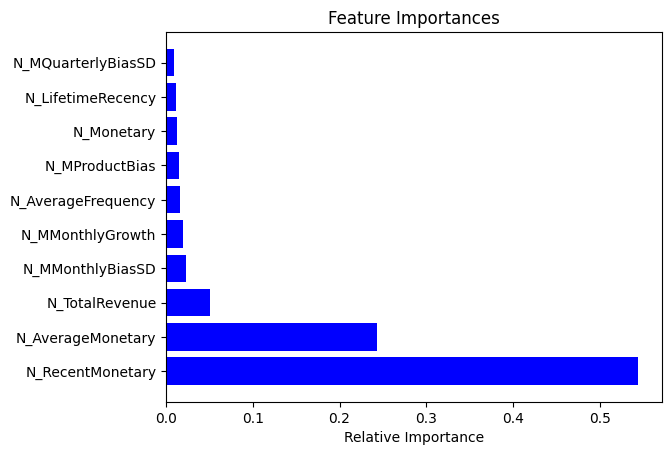

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
revenue_pred_rf = model.predict(X_test)

r2_rf = r2_score(y_test, revenue_pred_rf)
rmse_rf = mean_squared_error(y_test, revenue_pred_rf, squared=False)

r2_rf, rmse_rf

(0.5025008899418575, 216.68738464743296)

### 2.4 XGBoost

In [ ]:
#!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

# Predict the revenue for the test data
y_pred = xgb_regressor.predict(X_test)

# Calculate R^2 and RMSE for the predictions
r2_xgb = r2_score(y_test, y_pred)
rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)

r2_xgb, rmse_xgb

(0.4735738909582252, 222.89800635469413)

In [ ]:
stop

NameError: name 'stop' is not defined

### 2.5 AutoML

In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.18+9-LTS-195, mixed mode)
  Starting server from C:\Users\shih_\anaconda3\envs\AD\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\shih_\AppData\Local\Temp\tmpvwmj0ove
  JVM stdout: C:\Users\shih_\AppData\Local\Temp\tmpvwmj0ove\h2o_shih__started_from_python.out
  JVM stderr: C:\Users\shih_\AppData\Local\Temp\tmpvwmj0ove\h2o_shih__started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,4 months and 9 days
H2O_cluster_name:,H2O_from_python_shih__j09wj1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.924 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [ ]:
h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))

predictors = X_train.columns.tolist()
target = 'MARRIOTT_REVENUE'

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
#aml_v1 = H2OAutoML(max_runtime_secs=60, max_models=20, seed=1)
#aml_v1.train(predictors, target, training_frame=h2o_train)

AutoML progress: |
19:09:01.404: AutoML: XGBoost is not available; skipping it.

████████
19:09:11.248: GLM_1_AutoML_1_20231029_190900 [GLM def_1] failed: DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space

██████████████████

### 2.6 Deep Learning

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from tpot import TPOTRegressor
import numpy as np

# Deep Learning
dl = MLPRegressor(hidden_layer_sizes=(100,), max_iter=5000, random_state=42)
dl.fit(X_train, y_train)
dl_predictions = dl.predict(X_test)

dl_r2 = r2_score(y_test, dl_predictions)
dl_rmse = np.sqrt(mean_squared_error(y_test, dl_predictions))
dl_r2, dl_rmse

(0.5127198143166241, 214.4503945984181)

### 2.7 SVM

In [ ]:
# SVM
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

svm_r2 = r2_score(y_test, svm_predictions)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))
svm_r2, svm_rmse

(0.07680015916054728, 295.1789164369549)

### 2.8 Tree

In [ ]:
# Decision Tree
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_test)

tree_r2 = r2_score(y_test, tree_predictions)
tree_rmse = np.sqrt(mean_squared_error(y_test, tree_predictions))
tree_r2, tree_rmse

(0.09481876074313111, 292.28413704900976)

### 2.9 KNN

In [ ]:
# KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)

knn_r2 = r2_score(y_test, knn_predictions)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_predictions))
knn_r2, knn_rmse

(0.16782377703826112, 280.249679865522)

### 2.10 AutoML

In [ ]:
# AutoML
AutoML = TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2, scoring='r2', cv=5,
                       n_jobs=-1)
AutoML.fit(X_train, y_train)
AutoML_predictions = AutoML.predict(X_test)

AutoML_r2 = r2_score(y_test, AutoML_predictions)
AutoML_rmse = np.sqrt(mean_squared_error(y_test, AutoML_predictions))
AutoML_r2, AutoML_rmse

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5322099371013781

Generation 2 - Current best internal CV score: 0.5322099371013781

Generation 3 - Current best internal CV score: 0.5322099371013781

Generation 4 - Current best internal CV score: 0.5322099371013781

Generation 5 - Current best internal CV score: 0.548176286359204

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=13, n_estimators=100)


(0.5172739938044306, 213.44590241367837)

### 2.11 GBM

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbm.fit(X_train, y_train)

y_pred_gbm = gbm.predict(X_test)

# Calculate metrics
rmse_gbm = mean_squared_error(y_test, y_pred_gbm, squared=False)
r2_gbm = r2_score(y_test, y_pred_gbm)

print("GBM Performance:")
print("RMSE:", rmse_gbm)
print("R-squared:", r2_gbm)


GBM Performance:
RMSE: 212.09429094876728
R-squared: 0.5233682050769571


### 2.12 GLM

In [ ]:
import statsmodels.api as sm

# Reset indices
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# Add a constant to the model (it's required for statsmodels' GLM)
X_train_glm = sm.add_constant(X_train_reset)

# Initialize and fit the GLM model
glm = sm.GLM(y_train_reset, X_train_glm, family=sm.families.Gaussian())
glm_results = glm.fit()

# Print out the summary
print(glm_results.summary())

# For predictions, reset indices of X_test and add constant
X_test_reset = X_test.reset_index(drop=True)
X_test_glm = sm.add_constant(X_test_reset)

# Make predictions
y_pred_glm = glm_results.predict(X_test_glm)

# Calculate metrics
rmse_glm = mean_squared_error(y_test, y_pred_glm, squared=False)
r2_glm = r2_score(y_test, y_pred_glm)

print("\nGLM Performance:")
print("RMSE:", rmse_glm)
print("R-squared:", r2_glm)


                 Generalized Linear Model Regression Results                  
Dep. Variable:       MARRIOTT_REVENUE   No. Observations:                91878
Model:                            GLM   Df Residuals:                    91843
Model Family:                Gaussian   Df Model:                           34
Link Function:               identity   Scale:                          55062.
Method:                          IRLS   Log-Likelihood:            -6.3183e+05
Date:                Mon, 20 Nov 2023   Deviance:                   5.0571e+09
Time:                        17:18:40   Pearson chi2:                 5.06e+09
No. Iterations:                     4   Pseudo R-squ. (CS):             0.7574
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

### 2.13 Lasso & Ridge (Cross-Validation)

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardizing the data
scaler = StandardScaler()

# Lasso with Cross-Validation
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)  # Adjust the alphas and cv as needed
lasso_pipeline = make_pipeline(scaler, lasso_cv)
lasso_pipeline.fit(X_train, y_train)
y_pred_lasso_cv = lasso_pipeline.predict(X_test)

# Ridge with Cross-Validation
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)  # Adjust the alphas and cv as needed
ridge_pipeline = make_pipeline(scaler, ridge_cv)
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge_cv = ridge_pipeline.predict(X_test)

# Calculating RMSE and R^2
rmse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv, squared=False)
r2_lasso_cv = r2_score(y_test, y_pred_lasso_cv)

rmse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv, squared=False)
r2_ridge_cv = r2_score(y_test, y_pred_ridge_cv)

print("Lasso CV Regression:")
print("RMSE:", rmse_lasso_cv)
print("R^2:", r2_lasso_cv)
print("Optimal alpha (Lasso):", lasso_cv.alpha_)

print("\nRidge CV Regression:")
print("RMSE:", rmse_ridge_cv)
print("R^2:", r2_ridge_cv)
print("Optimal alpha (Ridge):", ridge_cv.alpha_)


C:\Users\xinyi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59156285.481861115, tolerance: 1044309.8134535294
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\xinyi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1637538329.389297, tolerance: 1044309.8134535294
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\xinyi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2057390409.575361, tolerance: 1044309.8134535294
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\xinyi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617

Lasso CV Regression:
RMSE: 216.5528059963005
R^2: 0.50311866441922
Optimal alpha (Lasso): 1e-06

Ridge CV Regression:
RMSE: 216.5019957533207
R^2: 0.503351805702595
Optimal alpha (Ridge): 100.0
